In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from math import log, sqrt 
import numpy as np
import matplotlib.pyplot as plt
from math import exp,  sqrt, log, ceil
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import bisect
from tqdm import tqdm
from compression import *

In [3]:
def variable_multishift_quantization(x, sigma):   
    u1 = np.random.uniform(size=x.shape)
    u2 = np.random.uniform(size=x.shape)
    n1 = sigma * np.random.normal(size=x.shape)
    # Stepsize calculations
    y_val = np.exp(-((n1 / sigma) ** 2) / 2) * u1
    y_val[n1 <= 0] = 1 - y_val[n1 <= 0]
    left = -sigma * np.sqrt(-2 * np.log(1 - y_val))
    right = sigma * np.sqrt(-2 * np.log(y_val))
    step_size = right - left
    bias = (right + left) / 2
    # Quantization
    x_prime = np.abs(x)
    s = np.sign(x)
    s[s == 0] = 1
    quants = np.ceil(x_prime / step_size + u2 - 0.5)
    bits = bit_count(quants) + np.sum(np.zeros_like(x) + 1)
    dequants = (quants - u2) * step_size * s + bias
    return dequants, bits

def multishift_upper_bound(c,n,sigma):
    indiv_sigma = sqrt(n)*sigma
    step_size = sqrt(log(4))*2*indiv_sigma
    steps = ceil(c/step_size)+2
    return max(log(steps, 2), 0)+1 #adding a sign bit
    
def bit_count(quants):
    N1 = np.floor(np.log2(quants[quants>1]))
    quants_prime = quants[quants>1] - 2**N1
    N2 = np.ceil(np.log2(quants_prime[quants_prime>1]))
    sr = np.sum(N1)+np.sum(N2)+np.sum(quants<=1)+np.sum(quants_prime<=1)
    return sr

def get_sigma(c, n , epsilon, delta):
    "Analytic Gaussian Mechanism"
    tri = 2*(c/n)
    b_plus = lambda x: norm.cdf(sqrt(epsilon*x)
                                )-exp(epsilon)*norm.cdf(-sqrt(epsilon*(x+2))) - delta
    b_minus = lambda x: norm.cdf(-sqrt(epsilon*x)
                                )-exp(epsilon)*norm.cdf(-sqrt(epsilon*(x+2))) - delta
    delta_0 = norm.cdf(0)-exp(epsilon)*norm.cdf(-sqrt(2*epsilon))
    
    if delta > delta_0:
        v = bisect(b_plus, 0, 1e4)
        alpha = sqrt(1+(v/2))-sqrt(v/2)
    else:
        u = bisect(b_minus, 0, 1e4)
        alpha = sqrt(1+(u/2))+sqrt(u/2)
    return (alpha*tri)/sqrt(2*epsilon)

In [4]:
def multishift_avg_bits(n,c,eps,delta,d=100, num_iter=20, seed=12345):
    d = 100
    rng = np.random.default_rng(seed)
    data  = rng.uniform(size=(n,d))
    data = c*data/np.linalg.norm(data, axis=1)[:,None]
    sd = get_sigma(c,n,eps,delta)
    indiv_sigma = sd*sqrt(n)
    bits = 0
    for i in range(num_iter):
        for i in range(n):
            bits+= variable_multishift_quantization(data[i,:], indiv_sigma)[1]
    return bits/(d*n*num_iter)
        

def agg_avg_bits(n,c,eps,delta, d=100, num_iter=20, seed=12345):
    def compress_count(x, n, rng):
            a, b = decompose(n, rng)
            s = rng.uniform(size=(n,))-0.5
            d = 2 * sd * np.sqrt(3 * n)
            quants =  np.round(x / (a * d) + s )
            return bit_count(np.abs(quants))+np.sum(np.ones(quants.shape))
    d = 100
    rng = np.random.default_rng(seed)
    data  = rng.uniform(size=(n,d))-0.5
    data = c*data/np.linalg.norm(data, axis=1)[:,None]
    sd = get_sigma(c,n,eps,delta)
    if n>10:
        sd *= sqrt(n/10) #Group wise
        bits = 0
        for m in tqdm(range(num_iter)):
            for k in range(int(n/10)):
                for i in range(d):
                    to_comp = data[k*10:(k+1)*10,i]
                    bits += compress_count(to_comp, 10,rng)
    else:    
        sd = get_sigma(c,n,eps,delta)
        bits = 0
        for k in tqdm(range(num_iter)):
            for i in range(d):
                to_comp = data[:,i]
                bits += compress_count(to_comp, n,rng)
    return (bits/(d*n*num_iter)) 

## Experiment 1


n = 250, d = 250, c = 10

In [8]:
n = 250
d = 250
c = 10
delta = 1e-5
eps_target = np.linspace(0.5, 6, 5)
multishift_upper = [multishift_upper_bound(c,n,get_sigma(c,n,e,delta )) for e in eps_target] #Invariant to d
multishift_avg = [multishift_avg_bits(n,c,e,delta, d=d) for e in eps_target]
agg_avg = [agg_avg_bits(n,c,e,delta, d=d) for e in eps_target]

  0%|          | 0/20 [00:00<?, ?it/s]/home/hegz/anaconda3/envs/qlsd/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)
/home/hegz/anaconda3/envs/qlsd/lib/python3.9/site-packages/scipy/special/_logsumexp.py:118: RuntimeWarning: invalid value encountered in log
  out = np.log(s)
100%|██████████| 20/20 [01:41<00:00,  5.07s/it]


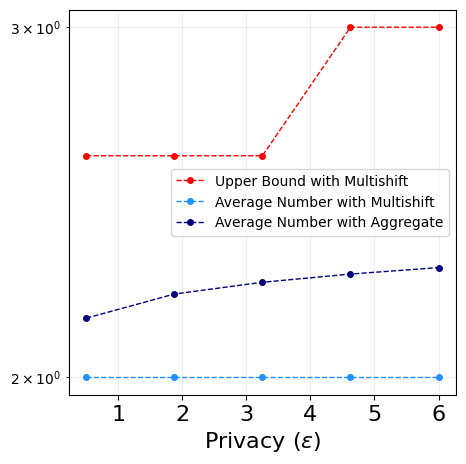

In [10]:
plt.figure(figsize=(5,5))
# CSGM
plt.plot(eps_target,multishift_upper,
      linestyle='--',label = rf'Upper Bound with Multishift',color='red',ms=4,
      marker='o',linewidth=1)
plt.plot(eps_target,multishift_avg,
      linestyle='--',label = rf'Average Number with Multishift',color='dodgerblue',ms=4,
      marker='o',linewidth=1)
plt.plot(eps_target,agg_avg,
      linestyle='--',label = rf'Average Number with Aggregate',color='navy',ms=4,
      marker='o',linewidth=1)
plt.legend(fontsize=10)
plt.xlabel(r'Privacy ($\varepsilon$)', fontsize=16)
# plt.text(0.0, 0.2, 'MSE', rotation=90,fontsize=16, va='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')
plt.grid(alpha=0.2,which='both')
plt.show()

## Experiment 2

n = 30, d = 100, c = 10

In [9]:
n = 30
d = 100
c = 10
delta = 1e-5
eps_target = np.linspace(0.5, 6, 5)
multishift_upper = [multishift_upper_bound(c,n,get_sigma(c,n,e,delta )) for e in eps_target] #Invariant to d
multishift_avg = [multishift_avg_bits(n,c,e,delta, d=d) for e in eps_target]
agg_avg = [agg_avg_bits(n,c,e,delta, d=d) for e in eps_target]

100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


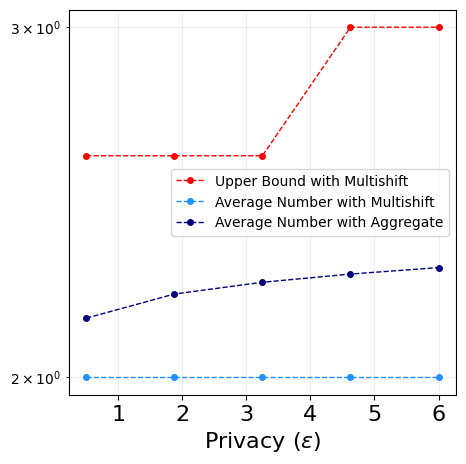

In [11]:
plt.figure(figsize=(5,5))
# CSGM
plt.plot(eps_target,multishift_upper,
      linestyle='--',label = rf'Upper Bound with Multishift',color='red',ms=4,
      marker='o',linewidth=1)
plt.plot(eps_target,multishift_avg,
      linestyle='--',label = rf'Average Number with Multishift',color='dodgerblue',ms=4,
      marker='o',linewidth=1)
plt.plot(eps_target,agg_avg,
      linestyle='--',label = rf'Average Number with Aggregate',color='navy',ms=4,
      marker='o',linewidth=1)
plt.legend(fontsize=10)
plt.xlabel(r'Privacy ($\varepsilon$)', fontsize=16)
# plt.text(0.0, 0.2, 'MSE', rotation=90,fontsize=16, va='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')
plt.grid(alpha=0.2,which='both')
plt.show()

## Experiment 3
n = 1000 d=250

In [12]:
n = 1_000
d = 100
c = 10
delta = 1e-5
eps_target = np.linspace(0.5, 6, 5)
multishift_upper = [multishift_upper_bound(c,n,get_sigma(c,n,e,delta )) for e in eps_target] #Invariant to d
multishift_avg = [multishift_avg_bits(n,c,e,delta, d=d) for e in eps_target]
agg_avg = [agg_avg_bits(n,c,e,delta, d=d) for e in eps_target]

  0%|          | 0/20 [00:00<?, ?it/s]/home/hegz/anaconda3/envs/qlsd/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)
/home/hegz/anaconda3/envs/qlsd/lib/python3.9/site-packages/scipy/special/_logsumexp.py:118: RuntimeWarning: invalid value encountered in log
  out = np.log(s)
100%|██████████| 20/20 [06:51<00:00, 20.58s/it]


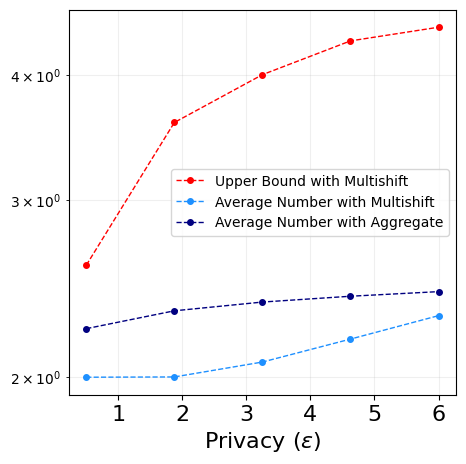

In [13]:
plt.figure(figsize=(5,5))
# CSGM
plt.plot(eps_target,multishift_upper,
      linestyle='--',label = rf'Upper Bound with Multishift',color='red',ms=4,
      marker='o',linewidth=1)
plt.plot(eps_target,multishift_avg,
      linestyle='--',label = rf'Average Number with Multishift',color='dodgerblue',ms=4,
      marker='o',linewidth=1)
plt.plot(eps_target,agg_avg,
      linestyle='--',label = rf'Average Number with Aggregate',color='navy',ms=4,
      marker='o',linewidth=1)
plt.legend(fontsize=10)
plt.xlabel(r'Privacy ($\varepsilon$)', fontsize=16)
# plt.text(0.0, 0.2, 'MSE', rotation=90,fontsize=16, va='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')
plt.grid(alpha=0.2,which='both')
plt.show()